In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import random
import time
from enum import Enum

# IA - Labyrinth

In [2]:
WALL_RATIO = 0.3
MAX_TIME_S = 5

In [3]:
def generate_labyrinth(width, height, wall_ratio=0.3):
    grid = np.random.rand(width, height)
    grid[grid >= 1 - wall_ratio] = 1
    grid[grid < 1 - wall_ratio] = 0
    free_cell_top = [i for i in range(0, width) if grid[0][i] != 1]
    start_idx = random.choice(free_cell_top)
    start_cell = (0, start_idx)
    free_cell_bottom = [i for i in range(0, width) if grid[-1][i] != 1]
    end_idx = random.choice(free_cell_bottom)
    end_cell = (height - 1, end_idx)
    return grid, start_cell, end_cell

In [4]:
def display_labyrinth(grid, start_cell, end_cell, solution=None):
    grid = np.array(grid, copy=True)
    FREE_CELL = 19
    WALL_CELL = 16
    START = 0
    END = 0
    PATH = 2
    grid[grid == 0] = FREE_CELL
    grid[grid == 1] = WALL_CELL
    grid[start_cell] = START
    grid[end_cell] = END
    if solution:
        solution = solution[1:]
        for cell in solution:
            grid[cell] = PATH
    else:
        print("No solution has been found")
    plt.matshow(grid, cmap="tab20c")

In [5]:
def load_grid(grid_file):
    grid = np.load(grid_file)
    h = grid.shape[0]
    w = grid.shape[1]
    return (grid, (h, w))

In [6]:
# grid, START_CELL, END_CELL = generate_labyrinth(WIDTH, HEIGHT, WALL_RATIO)
grid, size = load_grid("grids/grid40.npy")
WIDTH = size[0]
HEIGHT = size[1]
START_CELL = (0,0)
END_CELL = (size[0]-1,size[1]-1)
CHROMOSOME_LENGTH = int((WALL_RATIO*WIDTH*HEIGHT)//2)

No solution has been found
Width :  40  Height :  40
Chromosone Length :  240


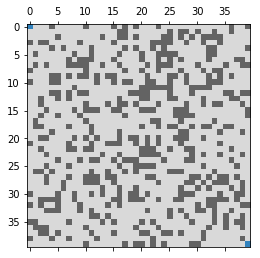

In [7]:
display_labyrinth(grid, START_CELL, END_CELL)
print("Width : ", WIDTH, " Height : ", HEIGHT)
print("Chromosone Length : ", CHROMOSOME_LENGTH)

# Data Structure

In [8]:
DIRECTIONS = {
    0: (-1, 0), # TOP
    1: (0, 1),  # RIGHT
    2: (1, 0),  # BOTTOM
    3: (0, -1), # LEFT
}
DIRECTIONS_LENGTH = len(DIRECTIONS)

## Generic tools

In [9]:
def check_duplication_point(location, direction, previous_locations):
    location_new = tuple(np.add(location, DIRECTIONS[direction]))
    return grid[location_new] != 1.0 and location_new not in previous_locations

In [10]:
def available_direction(location, previous_locations, start_location, targeted_location):
    directions = []
    
    if location[0] > 0:
        if check_duplication_point(location, 0, previous_locations):
            directions.append(0)
    if location[0] < HEIGHT-1:
        if check_duplication_point(location, 2, previous_locations):
            directions.append(2)
            directions.append(2)
    if location[1] > 0:
        if check_duplication_point(location, 3, previous_locations):
            directions.append(3)
    if location[1] < WIDTH-1:
        if check_duplication_point(location, 1, previous_locations):
            directions.append(1)
            directions.append(1)
    
    return directions

In [11]:
def available_direction_simple(location):
    directions = []
    
    if location[0] > 0:
        location_new = tuple(np.add(location, DIRECTIONS[0]))
        if grid[location_new] != 1.0:
            directions.append(0)
    if location[0] < HEIGHT-1:
        location_new = tuple(np.add(location, DIRECTIONS[2]))
        if grid[location_new] != 1.0:
            directions.append(2)
    if location[1] > 0:
        location_new = tuple(np.add(location, DIRECTIONS[3]))
        if grid[location_new] != 1.0:
            directions.append(3)
    if location[1] < WIDTH-1:
        location_new = tuple(np.add(location, DIRECTIONS[1]))
        if grid[location_new] != 1.0:
            directions.append(1)
    
    return directions

In [12]:
def validate_individual(individual, start_location, targeted_location):
    previous_locations = set([start_location])
    location = start_location
    direction = None
    end = False
    
    for index, direction in enumerate(individual):
        if end:
            continue
        
        # Validate every direction in an individual
        directions = available_direction(location, previous_locations, start_location, targeted_location)
        if len(directions) == 0:
            direction = random.choice(available_direction_simple(location))
        elif direction not in directions:
            # Find another valid direction
            direction = random.choice(directions)
        
        # Compute new location
        location = tuple(np.add(location, DIRECTIONS[direction]))
        
        individual[index] = direction
        previous_locations.add(location)
        
        if location == targeted_location:
            end = True
    
    return individual#, previous_locations

In [13]:
def compute_direction_to_path(individual, start_location):
    locations = [start_location]
    location = start_location
    for direction in individual:
        location = tuple(np.add(location, DIRECTIONS[direction]))
        locations.append(location)
    return locations

In [14]:
def evaluate(individual, start_location, targeted_location):
    individual = validate_individual(individual, start_location, targeted_location)
    
    # Add coefficient for length of the path
    score = len(individual)
    
    # Add double coefficient for Manhattan distance
    # TODO Improve
    locations = compute_direction_to_path(individual, start_location)
    distance = tuple(np.subtract(locations[-1], targeted_location))
    manhattan_distance = abs(distance[0])+abs(distance[1])
    
    score = score + 2*manhattan_distance
    return score, score

## Deap Framework

In [15]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
import operator
from enum import Enum
from collections import namedtuple
import random
import time

In [16]:
toolbox = base.Toolbox()

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [17]:
#toolbox.register("individual", init_individual, CHROMOSOME_LENGTH_START)
toolbox.register("direction", random.randint, 0, DIRECTIONS_LENGTH-1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.direction, CHROMOSOME_LENGTH)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

#toolbox.register("mate", tools.cxOnePoint)
toolbox.register("validate", validate_individual, start_location=START_CELL, targeted_location=END_CELL)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selRoulette)
toolbox.register("evaluate", evaluate, start_location=START_CELL, targeted_location=END_CELL)

In [18]:
population = toolbox.population(300)
elites = tools.HallOfFame(1)

In [19]:
res = algorithms.eaSimple(population, toolbox, 0.7, 0.1, 1, halloffame=elites, verbose=False)

In [20]:
elites[0].fitness

deap.creator.FitnessMin((240.0,))

No solution has been found


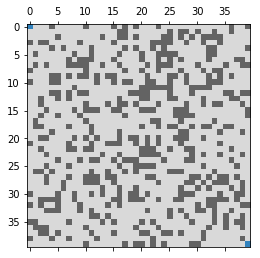

In [21]:
display_labyrinth(grid, START_CELL, END_CELL)

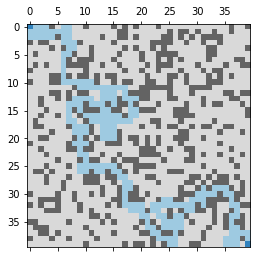

In [22]:
solution = compute_direction_to_path(elites[0], START_CELL)
if END_CELL in solution:
    solution = solution[:solution.index(END_CELL)]

display_labyrinth(grid, START_CELL, END_CELL, solution)

In [23]:
def solve_labyrinth(grid, start_cell, end_cell, max_time_s):
    population = toolbox.population(500)
    cxpb = 0.7
    mutpb = 0.1
    halloffame=elites

    start_time = inter_time = time.time()
    
    toolbox.map(toolbox.validate, population)
    for pop in population:
        #print(pop)
        pass
    
    # Evaluate the individuals with an invalid fitness
    fitnesses = toolbox.map(toolbox.evaluate, population)
    for pop in population:
        #print(pop)
        pass
    
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    # Begin the generational process
    while inter_time - start_time < max_time_s:
        # Select the next generation individuals
        offspring = map(toolbox.validate,toolbox.select(population, len(population)))

        # Vary the pool of individuals
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring
        
        inter_time = time.time()
        
    res = population

    solution = compute_direction_to_path(elites[0], START_CELL)
    if END_CELL in solution:
        solution = solution[:solution.index(END_CELL)]
    
    print("Length : ", len(solution))
    display_labyrinth(grid, START_CELL, END_CELL, solution)

Length :  240


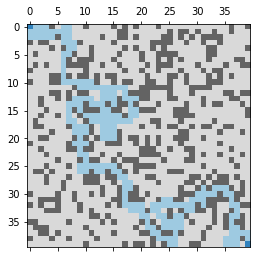

In [24]:
solve_labyrinth(grid, START_CELL, END_CELL, MAX_TIME_S)